<a href="https://colab.research.google.com/github/sarcasticvibes/Face-Mask-Detection-via-Detectron2/blob/master/Face_Mask_Detection_via_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarcasticvibes","key":"41883d4fbccff1f3662a136f9c271ee4"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d wobotintelligence/face-mask-detection-dataset

100% 2.50G/2.50G [00:35<00:00, 77.3MB/s]
100% 2.50G/2.50G [00:35<00:00, 75.5MB/s]


In [5]:
! unzip face-mask-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Medical mask/Medical mask/Medical Mask/images/1093.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1094.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1095.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1096.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1097.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1098.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1099.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1101.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1102.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1103.png  
  inflating: Medical mask/Medical mask/Medical Mask/images/1104.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1105.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1106.jpg  
  inflating: Medical mask/Medical mask/

In [6]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=67e2783d44c46667dabf9e390e91aafb830988c5835d237ab5bd62f58997f48c
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-re8hkum6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-re8hkum6
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [7]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 544kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200613-cp36-none-any.whl size=41028 sha256=b7d8e3d579c3e1f2fe083fccbea0959801b8703d32948d360b65c2377f80ea18
  Stored in directory: /root/.cache/pip/wheels/bf/54/92/c61c94b4b7c491dec867d287a75ef6fa0a536ab64920e8b778
Successfully built fvcore


In [0]:
import os
import torch
import pandas as pd
import torch.nn as nn
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn import model_selection
from sklearn import metrics
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
import random
import cv2

In [1]:
import torch
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [0]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [0]:
df = pd.read_csv('/content/train.csv')

In [11]:
df

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
...,...,...,...,...,...,...
15407,1894.jpg,437,121,907,644,face_with_mask
15408,1894.jpg,557,363,876,636,mask_surgical
15409,1894.jpg,411,3,940,325,hat
15410,3216.png,126,69,409,463,face_with_mask


In [0]:
img_folder_dir = '/content/Medical mask/Medical mask/Medical Mask/images'

In [0]:
! mkdir /content/image_pickles

In [20]:
import joblib
for image in tqdm(os.listdir(img_folder_dir), total=len(os.listdir(img_folder_dir))):
  im = np.array(Image.open(f'{img_folder_dir}/{image}'))
  image_id = image[:-4] if '.jpeg' not in image else image[:-5]
  assert int(image_id)
  joblib.dump(im, f"/content/image_pickles/{image_id}.pkl")

In [0]:
categories = {j:i for i, j in enumerate(df.classname.unique())}

In [14]:
categories

{'balaclava_ski_mask': 18,
 'eyeglasses': 7,
 'face_no_mask': 2,
 'face_other_covering': 5,
 'face_shield': 9,
 'face_with_mask': 0,
 'face_with_mask_incorrect': 3,
 'gas_mask': 17,
 'goggles': 13,
 'hair_net': 14,
 'hat': 12,
 'helmet': 8,
 'hijab_niqab': 15,
 'hood': 11,
 'mask_colorful': 1,
 'mask_surgical': 4,
 'other': 16,
 'scarf_bandana': 6,
 'sunglasses': 10,
 'turban': 19}

In [0]:
def get_train_dataset():
  train_data = []
  for img in df.name.unique():
    record = {}
    image_id = img[:-4] if '.jpeg' not in img else img[:-5]
    height, width, _ = np.array(Image.open(f'{img_folder_dir}/{img}')).shape
    record['file_name'] = f'{img_folder_dir}/{img}'
    record["image_id"] = image_id
    record["height"] = height
    record["width"] = width

    objs = []
    d = df[df['name'] == img]
    x1, x2, y1, y2, labels = d.x1.values, d.x2.values, d.y1.values, d.y2.values, d.classname.values
    annos = [(x1_, y1_, x2_, y2_) for x1_ ,y1_, x2_, y2_ in zip(x1, y1, x2, y2)]
    polys = [[(x1_, y1_), (x1_, y2_), (x2_, y1_), (x2_, y2_)] for x1_ ,y1_, x2_, y2_ in zip(x1, y1, x2, y2)]
    for anno, poly, label in zip(annos, polys, labels):
      obj = {
              "bbox": anno,
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": categories[label],
              "iscrowd": 0
          }
      objs.append(obj)
    record["annotations"] = objs
    train_data.append(record)
  return train_data

In [0]:
get_train_dataset()

In [0]:
d="train"
DatasetCatalog.register("Face_Mask_Detection_TrainingSet", lambda d=d: get_train_dataset())
MetadataCatalog.get("Face_Mask_Detection_TrainingSet").set(thing_classes=[class_ for class_ in df.classname.unique()])
text_metadata = MetadataCatalog.get("Face_Mask_Detection_TrainingSet")

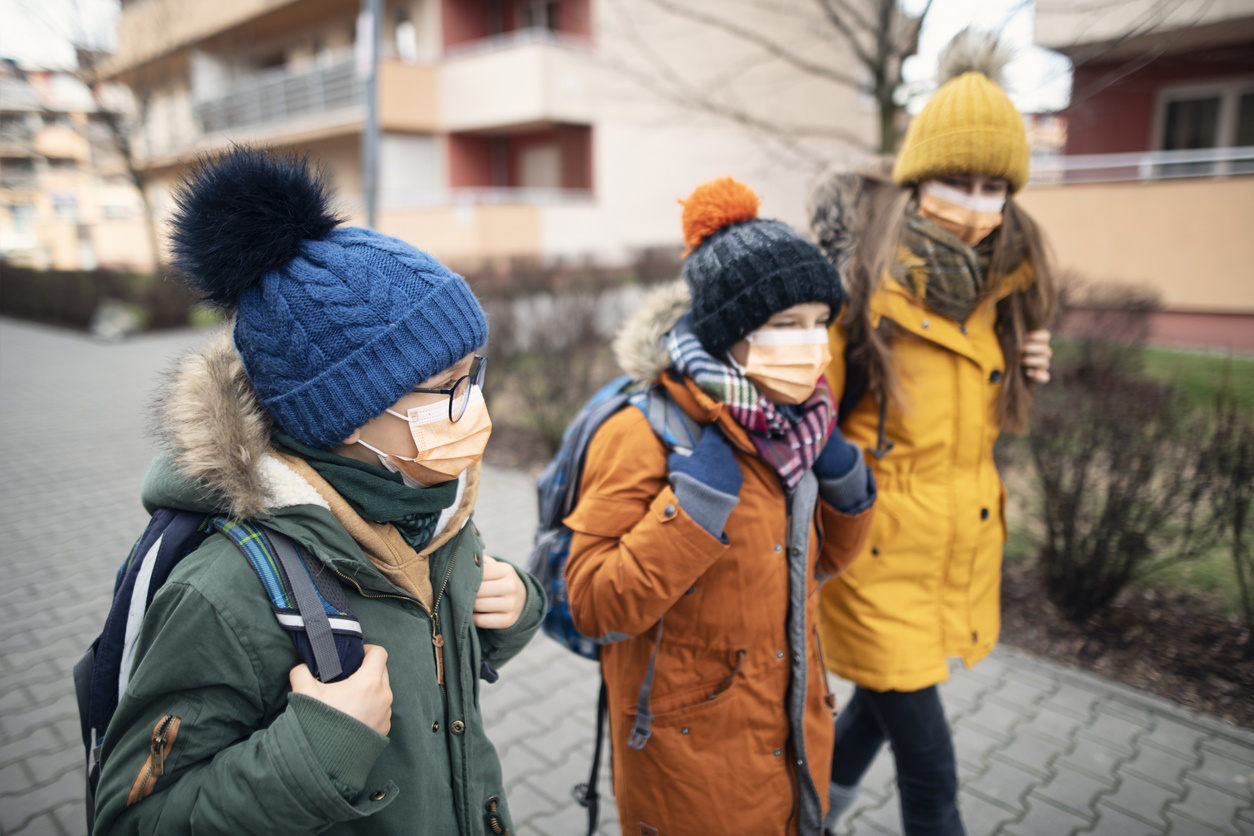

In [21]:
Image.open(f'{img_folder_dir}/1799.jpg')

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Face_Mask_Detection_TrainingSet",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  
cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.00002  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20  # only has one class (text)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/13 10:46:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (21, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (21,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (80, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (80,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (20, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (20,) in the model!


[06/13 10:48:20 d2.engine.train_loop]: Starting training from iteration 0
[06/13 10:48:55 d2.utils.events]:  eta: 0:41:09  iter: 19  total_loss: 4.801  loss_cls: 3.050  loss_box_reg: 0.079  loss_mask: 0.693  loss_rpn_cls: 0.818  loss_rpn_loc: 0.145  time: 1.7406  data_time: 0.4426  lr: 0.000004  max_mem: 11681M
[06/13 10:49:29 d2.utils.events]:  eta: 0:40:36  iter: 39  total_loss: 5.058  loss_cls: 2.914  loss_box_reg: 0.085  loss_mask: 0.693  loss_rpn_cls: 1.172  loss_rpn_loc: 0.234  time: 1.7121  data_time: 0.3160  lr: 0.000008  max_mem: 11681M
[06/13 10:50:03 d2.utils.events]:  eta: 0:40:00  iter: 59  total_loss: 4.353  loss_cls: 2.647  loss_box_reg: 0.082  loss_mask: 0.693  loss_rpn_cls: 0.777  loss_rpn_loc: 0.120  time: 1.7092  data_time: 0.3981  lr: 0.000012  max_mem: 11681M
[06/13 10:50:37 d2.utils.events]:  eta: 0:39:28  iter: 79  total_loss: 3.654  loss_cls: 2.248  loss_box_reg: 0.079  loss_mask: 0.693  loss_rpn_cls: 0.592  loss_rpn_loc: 0.086  time: 1.7122  data_time: 0.4356  